In [1]:
sc.version

'3.4.0'

# Imports

In [1]:
from pathlib import Path
import os
import subprocess
import time
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StringType, BooleanType, IntegerType

# Define directories

In [2]:
# Define directories

# dir_raw:     full path to nfs directory where the patstat files are stored
# dir_parquet: full path to hdfs directory where the parquet tables will be stored

dir_raw = Path("/export/clusterdata/jarenas/Datasets/patstat/2023_Spring/rawdata")
dir_parquet = Path("/export/ml4ds/IntelComp/Datalake/patstat/2023_Spring/parquet")

In [3]:
# Configuration hdfs
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
hdfs_dir_parquet = spark._jvm.org.apache.hadoop.fs.Path(dir_parquet.as_posix())

# Create output directories if they do not exist
if not fs.exists(hdfs_dir_parquet):
    fs.mkdirs(hdfs_dir_parquet)


# Create PATSTAT parquet files

## Export all tables as parquet files (tlsXXX.parquet)

In [17]:
%%time

# Very important: All PATSTAT files should have been decompressed to csv format, 
# and stored in NFS directory dir_raw

tables = list(set([el.name.split("_")[0] for el in list(dir_raw.glob('*.csv'))]))

for tbl in sorted(tables):
    
    # Read data in all csv files for this table
    df = spark.read.csv(f"file://{dir_raw.joinpath(tbl).as_posix()}*.csv", header=True)
    
    # Save to parquet
    df.write.parquet(
        dir_parquet.joinpath(f"{tbl}.parquet").as_posix(),
        mode="overwrite",
    )
    print("Processed table", tbl, "- Rows:", df.count())

23/05/25 21:50:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Processed table tls201 - Rows: 125295545


Processed table tls202 - Rows: 104805234


Processed table tls203 - Rows: 82550726


Processed table tls204 - Rows: 48772406


Processed table tls205 - Rows: 4161484


Processed table tls206 - Rows: 88820665


Processed table tls207 - Rows: 341398061


Processed table tls209 - Rows: 330847313


Processed table tls210 - Rows: 25988372


Processed table tls211 - Rows: 148140890


Processed table tls212 - Rows: 488181499


Processed table tls214 - Rows: 35760785


Processed table tls215 - Rows: 955043705


Processed table tls216 - Rows: 4798775


Processed table tls222 - Rows: 374429166


Processed table tls224 - Rows: 372088875


Processed table tls225 - Rows: 185861490


Processed table tls226 - Rows: 108180938


Processed table tls227 - Rows: 443089212


Processed table tls228 - Rows: 252890340


Processed table tls229 - Rows: 146664927


Processed table tls230 - Rows: 147455357


Processed table tls231 - Rows: 414266137
Processed table tls801 - Rows: 240
Processed table tls803 - Rows: 4105
Processed table tls901 - Rows: 766
Processed table tls902 - Rows: 850
Processed table tls904 - Rows: 2056
CPU times: user 3.14 s, sys: 613 ms, total: 3.75 s
Wall time: 1h 1min 15s


### Running some tests

#### Verify that Abstracts look good

In [18]:
query = "select * from parquet.`/export/ml4ds/IntelComp/Datalake/patstat/2023_Spring/parquet/tls203.parquet`"
df = spark.sql(query)
#df = df.filter(df.appln_abstract_lg=="en")
print(df.count())
df.printSchema()
df.show(n=2, vertical=True)

23/05/25 23:45:34 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/05/25 23:45:34 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/05/25 23:45:37 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/05/25 23:45:37 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore jarenas@192.168.148.147
23/05/25 23:45:37 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/05/25 23:45:37 WARN ObjectStore: Failed to get database parquet, returning NoSuchObjectException


82550726
root
 |-- appln_id: string (nullable = true)
 |-- appln_abstract_lg: string (nullable = true)
 |-- appln_abstract: string (nullable = true)

-RECORD 0---------------------------------
 appln_id          | 19836776             
 appln_abstract_lg | en                   
 appln_abstract    | Two flanges are j... 
-RECORD 1---------------------------------
 appln_id          | 19836778             
 appln_abstract_lg | en                   
 appln_abstract    | The device to gen... 
only showing top 2 rows



#### Count NPL publications with DOI, and how many can be matched to Semantic Scholar DOIs

In [27]:
query = "select * from parquet.`/export/ml4ds/IntelComp/Datalake/patstat/2023_Spring/parquet/tls214.parquet`"
df = spark.sql(query)
df = df.filter(F.col("npl_doi").isNotNull())

print('NPL elements with DOI:', df.count())
#df.printSchema()
#df.show(n=2, vertical=True)

query = "select doi from parquet.`/export/ml4ds/IntelComp/Datalake/semanticscholar/20230418/parquet/papers.parquet`"
df2 = spark.sql(query)

matches = df.join(df2, df.npl_doi ==  df2.doi, "inner").count()
print('Matches with Semantic Scholar:', matches)


23/05/25 23:56:00 WARN ObjectStore: Failed to get database parquet, returning NoSuchObjectException
23/05/25 23:56:05 WARN ObjectStore: Failed to get database parquet, returning NoSuchObjectException


NPL elements with DOI: 1141639


Matches with Semantic Scholar: 664695


#### Find DocDB families, and also wether applications in the same DOCDB family share the title and / or abstract

In [39]:
query = "select * from parquet.`/export/ml4ds/IntelComp/Datalake/patstat/2023_Spring/parquet/tls201.parquet`"
df = spark.sql(query)

print("Number of applications", df.count())
print("Number of DOCDB families", df.select("DOCDB_FAMILY_ID").distinct().count())
print("Number of INPADOC families", df.select("INPADOC_FAMILY_ID").distinct().count())


23/05/26 00:15:23 WARN ObjectStore: Failed to get database parquet, returning NoSuchObjectException


Number of applications 125295545


Number of DOCDB families 92731228


Number of INPADOC families 81070295


In [58]:
query = "select * from parquet.`/export/ml4ds/IntelComp/Datalake/patstat/2023_Spring/parquet/tls202.parquet`"
df_abstracts = spark.sql(query)
df = df.join(df_abstracts, df.appln_id ==  df_abstracts.appln_id, "inner").drop(df_abstracts.appln_id)

print("Number of applications", df.count())
print("Number of DOCDB families", df.select("DOCDB_FAMILY_ID").distinct().count())
print("Number of INPADOC families", df.select("INPADOC_FAMILY_ID").distinct().count())


23/05/26 00:35:12 WARN ObjectStore: Failed to get database parquet, returning NoSuchObjectException


Number of applications 82366296


Number of DOCDB families 61104102


Number of INPADOC families 59167191


In [59]:
df_pandas = df.groupBy("DOCDB_FAMILY_ID").agg(F.collect_list("appln_title").alias("group_values")).sample(withReplacement=False, fraction=1e-4).collect()

In [60]:
len(df_pandas)

6140

In [62]:
sum([len(set(el[1])) for el in df_pandas])

7439

## Create a new table for Patent Applications `patstat_appln.parquet`

In [64]:
%%time

df_201 = spark.read.parquet(dir_parquet.joinpath(f"tls201.parquet").as_posix())
df_202 = spark.read.parquet(dir_parquet.joinpath(f"tls202.parquet").as_posix())
df_203 = spark.read.parquet(dir_parquet.joinpath(f"tls203.parquet").as_posix())

patstat_appln = (df_201.join(df_202, df_201.appln_id ==  df_202.appln_id, "left")
                      .drop(df_202.appln_id)
                      .join(df_203, df_201.appln_id ==  df_203.appln_id, "left")
                      .drop(df_203.appln_id)
                )

patstat_appln.write.parquet(
        dir_parquet.joinpath(f"patstat_appln.parquet").as_posix(),
        mode="overwrite",
    )

print("Created table patstat_appln", "- Rows:", patstat_appln.count())

Created table patstat_appln - Rows: 125295545
CPU times: user 416 ms, sys: 62.3 ms, total: 478 ms
Wall time: 6min 14s


In [65]:
patstat_appln = spark.read.parquet(dir_parquet.joinpath(f"patstat_appln.parquet").as_posix())
patstat_appln = patstat_appln.filter(patstat_appln.appln_abstract.isNotNull())
patstat_appln.count()

82550726

## Create a new table for citations `npl_citations.parquet`

In [66]:
# Key bibliographical data elements relevant to identify patent publications
pub = spark.read.parquet(dir_parquet.joinpath("tls211.parquet").as_posix()).select(
        "pat_publn_id", "publn_kind", "appln_id"
    )

# NPL publications
npl = spark.read.parquet(dir_parquet.joinpath("tls214.parquet").as_posix()).select("npl_publn_id", "npl_doi")

# Links between publications, applications and non-patent literature documents with regards to citations.
cit = spark.read.parquet(dir_parquet.joinpath("tls212.parquet").as_posix()).select(
        "pat_publn_id",
        "cited_pat_publn_id",
        "cited_appln_id",
        "cited_npl_publn_id",
    )

# Citations from patent publications to other patent applications
cit_appln = cit.select("pat_publn_id", "cited_appln_id").where(
        (F.col("cited_appln_id").isNotNull()) & (F.col("cited_appln_id") != "0")
    )

# Citations to from patent publications to other patent publications
cit_publn = cit.select("pat_publn_id", "cited_pat_publn_id").where(
        (F.col("cited_pat_publn_id").isNotNull()) & (F.col("cited_pat_publn_id") != "0")
    )
    
# Citations from patent publications to NPL publications
cit_npl = cit.select("pat_publn_id", "cited_npl_publn_id").where(
        (F.col("cited_npl_publn_id").isNotNull()) & (F.col("cited_npl_publn_id") != "0")
    )

print("Number of citations to patent applications:", cit_appln.count())
print("Number of citations to other patent publications:", cit_publn.count())
print("Number of citations to NPL publications:", cit_npl.count())

Number of citations to patent applications: 829033


Number of citations to other patent publications: 416833302


Number of citations to NPL publications: 71450314


We will create only a table from citations from PATSTAT to NPL

In [70]:
cit_pat_npl = (
    cit_npl.join(
        pub,
        cit_npl.pat_publn_id == pub.pat_publn_id,
            "left",
    )
    .drop(pub.pat_publn_id)
    .join(
        npl,
        cit_npl.cited_npl_publn_id == npl.npl_publn_id,
            "left",
        )
    .drop(npl.npl_publn_id)
    .select(
        "appln_id",
        "pat_publn_id",
        "publn_kind",
        "cited_npl_publn_id",
        "npl_doi",
    )
)


In [71]:
cit_pat_npl.show(n=3, vertical=True)

-RECORD 0----------------------------------
 appln_id           | 267644294            
 pat_publn_id       | 333677275            
 publn_kind         | B2                   
 cited_npl_publn_id | 0B25326D756A8D73F... 
 npl_doi            | null                 
-RECORD 1----------------------------------
 appln_id           | 23689455             
 pat_publn_id       | 283268961            
 publn_kind         | A1                   
 cited_npl_publn_id | 954E23391130912A3... 
 npl_doi            | null                 
-RECORD 2----------------------------------
 appln_id           | 50545425             
 pat_publn_id       | 416953167            
 publn_kind         | B2                   
 cited_npl_publn_id | DBD5404C562A201BD... 
 npl_doi            | null                 
only showing top 3 rows



In [73]:
cit_pat_npl.write.parquet(
        dir_parquet.joinpath(f"npl_citations.parquet").as_posix(),
        mode="overwrite",
)

In [74]:
print("Total number of citations to NPL:", cit_pat_npl.count())
print("Total number with DOS:", cit_pat_npl.filter(F.col("npl_doi").isNotNull()).count())

Total number of citations to NPL: 71450314


Total number with DOS: 1938151


ERROR:root:Exception while sending command.                                     
Traceback (most recent call last):
  File "/opt/spark-3.4.0-bin-3.3.1/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/spark-3.4.0-bin-3.3.1/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/spark-3.4.0-bin-3.3.1/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
/opt/spark-3.4.0-bin-3.3.1/python/pyspark/context.py:654: RuntimeWarning: Unable to cleanly shutdown Spark JVM process. It is possible that the process has crashe

# Generate data for the IMT Training Data sets

In [4]:
query = "select appln_id, docdb_family_id, appln_title, appln_title_lg, appln_abstract, appln_abstract_lg, appln_filing_year, earliest_filing_year, "
query += "granted, appln_auth, receiving_office, ipr_type from parquet.`/export/ml4ds/IntelComp/Datalake/patstat/2023_Spring/parquet/patstat_appln.parquet`"
df_patents = spark.sql(query)

df_patents = df_patents.filter(F.col("appln_abstract").isNotNull()).filter(df_patents.appln_abstract_lg=="en")

print('Number of patents with abstract in English language:', df_patents.count())
df_patents.printSchema()
df_patents.show(n=2, truncate=120, vertical=True)

23/05/26 23:21:44 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/05/26 23:21:44 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/05/26 23:21:46 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/05/26 23:21:46 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore jarenas@192.168.148.147
23/05/26 23:21:46 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/05/26 23:21:46 WARN ObjectStore: Failed to get database parquet, returning NoSuchObjectException


Number of patents with abstract in English language: 75348760
root
 |-- appln_id: string (nullable = true)
 |-- docdb_family_id: string (nullable = true)
 |-- appln_title: string (nullable = true)
 |-- appln_title_lg: string (nullable = true)
 |-- appln_abstract: string (nullable = true)
 |-- appln_abstract_lg: string (nullable = true)
 |-- appln_filing_year: string (nullable = true)
 |-- earliest_filing_year: string (nullable = true)
 |-- granted: string (nullable = true)
 |-- appln_auth: string (nullable = true)
 |-- receiving_office: string (nullable = true)
 |-- ipr_type: string (nullable = true)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 appln_id             | 10000172                                                                                                                 
 docdb_family_id      | 5871993                                                                    

## Cancer datasets

### Filter according to CPC

In [5]:
query = "select appln_id, cpc_class_symbol from parquet.`/export/ml4ds/IntelComp/Datalake/patstat/2023_Spring/parquet/tls224.parquet`"
df_cpc = spark.sql(query)

print('Number of cpc entries:', df_cpc.count())
df_cpc.printSchema()
df_cpc.show(n=2, truncate=120, vertical=True)

23/05/26 23:22:50 WARN ObjectStore: Failed to get database parquet, returning NoSuchObjectException


Number of cpc entries: 372088875
root
 |-- appln_id: string (nullable = true)
 |-- cpc_class_symbol: string (nullable = true)

-RECORD 0-----------------------
 appln_id         | 26591291    
 cpc_class_symbol | C22C  18/04 
-RECORD 1-----------------------
 appln_id         | 26591291    
 cpc_class_symbol | H01M   4/42 
only showing top 2 rows



In [6]:
cancer_cpcs = ["C12Q1/6886","G01N33/574","A61K39/0011","G01N33/5011","G01N33/57484","C07K16/30","G01N33/57492","A61L2300/416","G01N33/57434","G01N33/53","G01N33/57423","G01N33/57419","G01N33/57415","G01N33/57407","G01N33/57488","C12N15/1135","A61K47/48569","G01N33/57438","G06T2207/30096","G01N33/57496","G01N33/57426","C07K16/3053","C07K16/3069","G01N33/57449","C12N5/0693","A23V2200/308","C07K16/3015","A61K47/48584","C07K16/3007","C07K16/3046","C07K16/3061","G01N33/57446","A61K2039/5152","A61K2039/585","C07K16/303","A61K51/1045","G01N2800/7028","G01N33/5743","A61K35/13","A61K47/48638","C07K16/3023","G01N33/5017","G01N33/5748","A61K35/768","A61K47/4863","G01N2333/82","G01N33/57411","C07K16/3076","A61K47/48615","G01N33/57442","Y10S436/813","A61K47/48576","A61K51/1072","C07K16/3038","A61K51/1057","A61K51/1048","C12N5/0093","A61K47/48607","Y10S977/911","A61K38/1764","G01N33/57476","G01N33/57469","A61K51/106","A61K45/05","G01N2033/57403","G01N2033/57461","G01N2033/57465","G01N2033/57453","G01N2033/57457"]
CPC_match_UDF = F.udf(lambda x: x.replace(' ', '') in cancer_cpcs, BooleanType())

# df_FOS.withColumn("FOS_source", myUDF(F.col("S2fieldsofstudy"))) \
#   .show(n=2, truncate=120, vertical=True)

df_cpc_cancer = df_cpc.withColumn("isCancer", CPC_match_UDF(F.col("cpc_class_symbol"))).filter("isCancer").drop("isCancer").cache()

print('Number of cpc entries:', df_cpc_cancer.count())

df_appln_cancer = df_cpc_cancer.groupBy("appln_id").agg(F.collect_list("cpc_class_symbol").alias("cpc_class_symbol"))

print('Number of applications:', df_appln_cancer.count())
df_appln_cancer.printSchema()
df_appln_cancer.show(n=2, truncate=120, vertical=True)

Number of cpc entries: 460673


Number of applications: 293084
root
 |-- appln_id: string (nullable = true)
 |-- cpc_class_symbol: array (nullable = false)
 |    |-- element: string (containsNull = false)



-RECORD 0----------------------------
 appln_id         | 10007045         
 cpc_class_symbol | [C12N   5/0693]  
-RECORD 1----------------------------
 appln_id         | 1001853          
 cpc_class_symbol | [G01N  33/57434] 
only showing top 2 rows



In [36]:
selected_CPC = df_patents.join(df_appln_cancer, df_patents.appln_id == df_appln_cancer.appln_id, "inner").drop(df_appln_cancer.appln_id)
print('Selected CPC:', selected_CPC.count())
selected_CPC.printSchema()
selected_CPC.show(n=2, truncate=120, vertical=True)

Selected CPC: 209547
root
 |-- appln_id: string (nullable = true)
 |-- docdb_family_id: string (nullable = true)
 |-- appln_title: string (nullable = true)
 |-- appln_title_lg: string (nullable = true)
 |-- appln_abstract: string (nullable = true)
 |-- appln_abstract_lg: string (nullable = true)
 |-- appln_filing_year: string (nullable = true)
 |-- earliest_filing_year: string (nullable = true)
 |-- granted: string (nullable = true)
 |-- appln_auth: string (nullable = true)
 |-- receiving_office: string (nullable = true)
 |-- ipr_type: string (nullable = true)
 |-- cpc_class_symbol: array (nullable = false)
 |    |-- element: string (containsNull = false)



-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 appln_id             | 128357                                                                                                                   
 docdb_family_id      | 37963490                                                                                                                 
 appln_title          | CANCER IMAGING AND TREATMENT                                                                                             
 appln_title_lg       | en                                                                                                                       
 appln_abstract       | A compound, or a pharmaceutically acceptable salt or ester thereof, comprises a ligand for the chemokine receptor CXC... 
 appln_abstract_lg    | en                                                                                                  

In [37]:
selected_CPC.repartition(40).write.parquet(
    dir_parquet.joinpath(f"patents_Cancer_CPC.parquet").as_posix(),
    mode="overwrite",
)

### Filter according to keywords matching

In [7]:
with open("/export/clusterdata/jarenas/Datasets/patstat/2023_Spring/Cancer_keywords_HCERES_patents.txt", "r") as fin:
    Cancer_kwds = [el.strip() for el in fin.readlines()]
    Cancer_kwds = [el for el in Cancer_kwds if len(el)]
print('Number of keywords:', len(Cancer_kwds))

Number of keywords: 123


In [41]:
def count_kwds(x):
    try:
        reps = [x.lower().count(k) for k in Cancer_kwds]
        return sum(reps)
    except:
        return 0

count_kwds_UDF = F.udf(count_kwds, IntegerType())

Cancer_patents = df_patents.withColumn('raw_text', 
                    F.concat(F.col('appln_title'),F.lit(' '), F.col('appln_abstract')))

Cancer_patents = Cancer_patents.withColumn("Kwd_count", count_kwds_UDF(F.col("raw_text")))
Cancer_patents = Cancer_patents.filter(Cancer_patents.Kwd_count > 0).cache()

print('Number of documents in Cancer dataset:', Cancer_patents.count())
Cancer_patents.show(n=2, truncate=120, vertical=True)

Number of documents in Cancer dataset: 580280
-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 appln_id             | 108231                                                                                                                   
 docdb_family_id      | 40263006                                                                                                                 
 appln_title          | RNAI-RELATED INHIBITION OF TNFA SIGNALING PATHWAY FOR TREATMENT OF OCULAR ANGIOGENESIS                                   
 appln_title_lg       | en                                                                                                                       
 appln_abstract       | RNA interference is provided for inhibition of tumor necrosis factor (TNF ) by silencing TNF cell surface receptor TN... 
 appln_abstract_lg    | en                                                    

In [42]:
counts = sorted([el[0] for el in Cancer_patents.select("Kwd_count").collect()])

In [43]:
Intersection = Cancer_patents.join(df_appln_cancer, Cancer_patents.appln_id ==  df_appln_cancer.appln_id, "inner")

In [44]:
counts2 = sorted([el[0] for el in Intersection.select("Kwd_count").collect()])

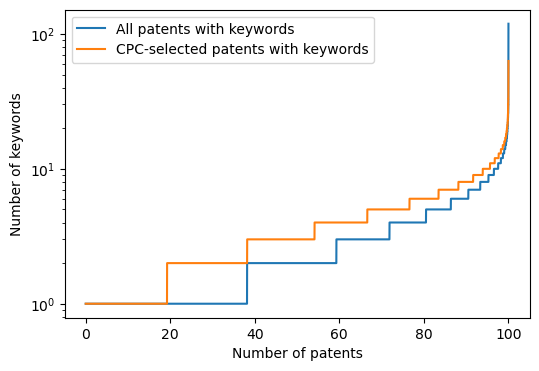

In [46]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))
plt.semilogy(np.linspace(0,100, len(counts)), counts)
plt.semilogy(np.linspace(0,100, len(counts2)), counts2)
plt.xlabel("Number of patents")
plt.ylabel("Number of keywords")
plt.legend(["All patents with keywords", "CPC-selected patents with keywords"])
plt.show()

In [47]:
Cancer_patents.drop("raw_text").repartition(40).write.parquet(
    dir_parquet.joinpath(f"patents_Cancer_Kwds.parquet").as_posix(),
    mode="overwrite",
)

### Filter according to citations to Cancer publications

In [20]:
query = "select PMID, externalids.doi as doi from parquet.`/export/ml4ds/IntelComp/Datalake/semanticscholar/20230418/parquet/papers.parquet`"
publis = spark.sql(query)
publis.count()

23/05/26 23:39:27 WARN ObjectStore: Failed to get database parquet, returning NoSuchObjectException


211633102

In [21]:
cancer_df = spark.read.parquet('file:///export/clusterdata/jarenas/Datasets/semanticscholar/20230418/PMID_Cancer.parquet')
cancer_df = cancer_df.withColumn("PMID", cancer_df.PMID.cast('string'))

In [22]:
cancerDOIS = cancer_df.join(publis, cancer_df.PMID ==  publis.PMID, "inner")
print(cancerDOIS.count())
cancerDOIS.printSchema()

2436965
root
 |-- PMID: string (nullable = true)
 |-- PMID: string (nullable = true)
 |-- doi: string (nullable = true)



In [26]:
query = "select appln_id, npl_doi as doi from parquet.`/export/ml4ds/IntelComp/Datalake/patstat/2023_Spring/parquet/npl_citations.parquet`"
citations = spark.sql(query)
citations.count()

23/05/26 23:45:07 WARN ObjectStore: Failed to get database parquet, returning NoSuchObjectException


71450314

In [27]:
citations = citations.filter(F.col("doi").isNotNull())
citations.count()
citations.show(n=2)

+---------+--------------------+
| appln_id|                 doi|
+---------+--------------------+
|574602294|10.1109/CVPRW5309...|
|478925350|10.1021/acs.chemm...|
+---------+--------------------+
only showing top 2 rows



In [29]:
print(citations.count())

1938151


In [30]:
intersect = citations.join(cancerDOIS, citations.doi==cancerDOIS.doi, "inner")

In [31]:
intersect.count()

159038

In [32]:
patents_PMID = intersect.select("appln_id").distinct()
patents_PMID.count()

77789

In [35]:
patents_PMID.join(Cancer_patents, patents_PMID.appln_id==Cancer_patents.appln_id, "inner").count()

29281

## AI dataset

### Filter according to keywords matching

In [40]:
with open("/export/clusterdata/jarenas/Datasets/semanticscholar/20230418/IA_keywords_SEAD_REV_JAG_JCS.txt", "r") as fin:
    AI_kwds = [el.strip() for el in fin.readlines()]
print('Number of keywords:', len(AI_kwds))

Number of keywords: 266


In [48]:
def count_kwds(x):
    try:
        reps = [x.lower().count(k) for k in AI_kwds]
        return sum(reps)
    except:
        return 0

count_kwds_UDF = F.udf(count_kwds, IntegerType())

AI_patents = df_patents.withColumn('raw_text', 
                    F.concat(F.col('appln_title'),F.lit(' '), F.col('appln_abstract')))

AI_patents = AI_patents.withColumn("Kwd_count", count_kwds_UDF(F.col("raw_text")))
AI_patents = AI_patents.filter(AI_patents.Kwd_count > 0).cache()

print('Number of documents in AI dataset:', AI_patents.count())
AI_patents.show(n=2, truncate=120, vertical=True)

Number of documents in AI dataset: 460820
-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------
 appln_id             | 10512667                                                                                                                 
 docdb_family_id      | 5523418                                                                                                                  
 appln_title          | Metal foreign body detection for steel reinforced conveyor belt - compares properties of belt before and after delive... 
 appln_title_lg       | en                                                                                                                       
 appln_abstract       | The detection of metal foreign bodies within material deposited on a steel wire reinforced conveyor belt is effected ... 
 appln_abstract_lg    | en                                                        

In [49]:
counts = sorted([el[0] for el in AI_patents.select("Kwd_count").collect()])

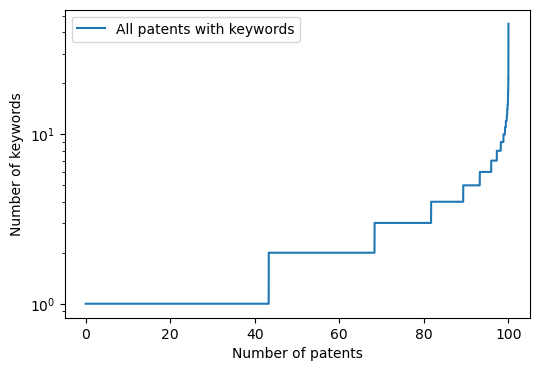

In [50]:
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(6,4))
plt.semilogy(np.linspace(0,100, len(counts)), counts)
plt.xlabel("Number of patents")
plt.ylabel("Number of keywords")
plt.legend(["All patents with keywords", "CPC-selected patents with keywords"])
plt.show()

In [51]:
AI_patents.drop("raw_text").repartition(40).write.parquet(
    dir_parquet.joinpath(f"patents_AI_Kwds.parquet").as_posix(),
    mode="overwrite",
)